In [2]:
import numpy as np
import scipy as sp
import suite2p as s2p
import TwoPUtils as tpu
import InVivoDA_analyses as da
import STX3KO_analyses as stx
import os
import shutil

import sbxreader

%matplotlib inline

%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [3]:
# from InVivoDA_analyses.path_dict_esay import path_dictionary as path_dict
from STX3KO_analyses.path_dicts.path_dict_esay import path_dictionary as path_dict

# options: path_dict_josquin, path_dict_msosamac, etc.
path_dict

{'preprocessed_root': 'C://Users\\esay\\data\\Stx3',
 'pkl_root': 'C://Users\\esay\\data\\Stx3\\YMazeSessPkls',
 'sbx_root': 'Z://giocomo\\InVivoDA\\2P_Data',
 'VR_Data': 'C://Users\\esay\\data\\Stx3\\VR_Data',
 'git_repo_root': 'C://repos',
 'TwoPUtils': 'C://repos\\TwoPUtils',
 'home': 'C://',
 'fig_dir': 'C://Users\\esay\\data\\Stx3\\fig_scratch'}

In [13]:
mouse = "SparseKO_08"
basedir = os.path.join(path_dict['preprocessed_root'],mouse) #"/mnt/BigDisk/2P_scratch/GRABDA15"
sbxdir = os.path.join(path_dict['sbx_root'],mouse) 

custom_nplanes = 1 # if needed to override empty optotune params

basedir, sbxdir

('C://Users\\esay\\data\\Stx3\\SparseKO_08',
 'Z://giocomo\\InVivoDA\\2P_Data\\SparseKO_08')

In [15]:
file_list = stx.ymaze_sess_deets.SparseKO_sessions[mouse]

file_list = [file_list[1]]
file_list

[{'date': '27_05_2025',
  'scene': 'YMaze_LNovel',
  'session': 1,
  'scan': 26,
  'novel_arm': 0,
  'exp_day': 2}]

In [16]:
# %%capture cap

for fn,f in enumerate(file_list):
    # f = file_list
    # scan = 2

    # Set data input and output paths
    fullpath = os.path.join(basedir,f['date'],f['scene'],"%s_%03d_%03d" % (f['scene'], f['session'], f['scan']))
    scanpath = os.path.join(sbxdir,f['date'],f['scene'],"%s_%03d_%03d" % (f['scene'], f['session'], f['scan']))
    h5path = os.path.join(basedir,f['date'],f['scene'],"%s_%03d_%03d.h5" % (f['scene'], f['session'], f['scan']))

    # load .mat header with metadata
    # scanpath = os.path.join(sbxdir,  "%s_000_00%d" % (mouse, scan))
    # fullpath = os.path.join(basedir, "%s_000_00%d" % (mouse, scan), "%s_000_00%d" % (mouse, scan))
    # h5path = os.path.join(basedir, "%s_000_00%d" % (mouse, scan), "%s_000_00%d.h5" % (mouse, scan))

    scanmat, sbxfile = scanpath+'.mat', scanpath+'.sbx'
    info = tpu.scanner_tools.sbx_utils.loadmat(scanmat, sbx_version=3)

    if len(info['etl_table'])>0:
        nplanes = info['etl_table'].shape[0]
    else:
        nplanes = custom_nplanes
        print('"etl_table" was empty; hardcoding %d planes' % nplanes)

    print('nplanes=',nplanes)

    print('pockmux:', info['pockmux'])
    # convert .sbx file to .h5
    # h5name = tpu.scanner_tools.sbx_utils.sbx2h5_cutdb_pockmux(scanpath, output_name=h5path, sbx_version=3) #, force_2chan=True)
    h5name = tpu.scanner_tools.sbx_utils.sbx2h5(scanpath,output_name=h5path, sbx_version=3) #, force_2chan=True)

    # run suite2p to run motion registration AND extract ROIs on the first
    # functional channel (channel 1, green, PMT0)
    ops_orig = tpu.s2p.set_ops(d={'data_path': [os.path.split(fullpath)[0]],
                           'save_path0': fullpath,
                           'fast_disk':[],
                           'move_bin':True,
                           'two_step_registration':True,
                           'maxregshiftNR':10,
                           'nchannels':2,
                           'tau': 0.7,
                           'functional_chan':1,
                            'align_by_chan' :1,
                           'nimg_init': 2000,
                           'fs':info['frame_rate'],
                           'roidetect':True,
                           'input_format':"h5", #h5
                           'h5py_key':'data',
                           'sparse_mode':True,
                           'threshold_scaling':.8, #.6
                            'sbx_ndeadcols': 100,
                            'nplanes':nplanes})

    ops_orig=s2p.run_s2p(ops=ops_orig)

    # # copy binary
    ops = ops_orig.copy()
    save_path_orig = ops_orig['save_path0']
    # ops['save_path0'] = os.path.join(save_path_orig,'chan2')
    ops['save_path'] = os.path.join(ops['save_path0'], 'chan2','suite2p', 'plane0')
    os.makedirs(ops['save_path'], exist_ok=True)
    
    ops['fast_disk'] = []

    orig_reg_file_1 = os.path.join(save_path_orig,'suite2p','plane0','data.bin') # the original data.nbin
    orig_reg_file_2 = os.path.join(save_path_orig,'suite2p','plane0','data_chan2.bin') # the original data_chan2.nbin

    ops['reg_file'] = os.path.join(ops['save_path'], 'data.bin') # create a path for the new reg_file (which is original chan 2)
    # orig_reg_file = os.path.join(save_path_orig,'suite2p','plane0','data.bin') # the original data.nbin

    # switch meanImg <-> meanImg_chan2
    mimg = np.copy(ops_orig['meanImg'])
    ops['meanImg'] = np.copy(ops_orig['meanImg_chan2'])
    ops['meanImg_chan2'] = mimg

    # switch reg_file paths (maybe don't need to actually copy the reg_file
    # ops['reg_file'] = orig_reg_file_2
    # ops['reg_file_chan2'] = orig_reg_file_1

    # copy chan2 reg file (original data_chan2.bin) to new location as "data.bin"
    shutil.copyfile(orig_reg_file_2, ops['reg_file'])
    print('red reg_file_chan2 copied to %s'%(ops['reg_file']))

    # now copy original chan1 reg file to new "data_chan2.bin"
    ops['reg_file_chan2'] = os.path.join(ops['save_path'], 'data_chan2.bin') # create a path for the new chan2 reg_file (which is original chan 1)
    shutil.copyfile(orig_reg_file_1, ops['reg_file_chan2'])
    print('green reg_file copied to %s'%(ops['reg_file_chan2']))
    
    # save new ops file with paths
    ops['ops_path'] = os.path.join(ops['save_path'],'ops.npy')
    ops['save_path0'] = os.path.join(ops['save_path0'], 'chan2') # need it to look here + suite2p/plane0/ for binaries that we copied

    np.save(ops['ops_path'], ops)
    
    ## Optional: update ROI threshold for the second channel
    ops['threshold_scaling'] = 1
    
    ## Run the ROI extraction for the second channel
    opsEnd=s2p.run_s2p(ops=ops)
    
    ## Optional: remove h5 file to save disk space
    !rm {h5name} 


"etl_table" was empty; hardcoding 1 planes
nplanes= 1
pockmux: 1
dset size <HDF5 dataset "data": shape (76032, 512, 796), type "<f4">
0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000
20000 21000
21000 22000
22000 23000
23000 24000
24000 25000
25000 26000
26000 27000
27000 28000
28000 29000
29000 30000
30000 31000
31000 32000
32000 33000
33000 34000
34000 35000
35000 36000
36000 37000
37000 38000
38000 39000
39000 40000
40000 41000
41000 42000
42000 43000
43000 44000
44000 45000
45000 46000
46000 47000
47000 48000
48000 49000
49000 50000
50000 51000
51000 52000
52000 53000
53000 54000
54000 55000
55000 56000
56000 57000
57000 58000
58000 59000
59000 60000
60000 61000
61000 62000
62000 63000
63000 64000
64000 65000
65000 66000
66000 67000
67000 68000
68000 69000
69000 70000
70000 71000
71000 72000
72000 73000
73000 74000


'rm' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
print(cap.stdout)
print(cap.stderr)

with open("output.txt", "w") as f:
    f.write(cap.stdout)
    f.write(cap.stderr)

### Run this cell to re-run the motion registration

In [ ]:
ops = ops_orig.copy()
save_path_orig = ops_orig['save_path0']
ops['save_path0'] = os.path.join(save_path_orig,'chan2')
ops['save_path'] = os.path.join(ops['save_path0'], 'suite2p', 'plane0')
os.makedirs(ops['save_path'], exist_ok=True)
ops['functional_chan'] = 2
ops['align_by_chan'] = 1
## currently this will extract and re-register a new binary from the same .h5 file (which is redundant)
opsEnd=s2p.run_s2p(ops=ops)

## Run these cells to copy binary files so you don't have to re-register

In [8]:
ops = ops_orig.copy()
save_path_orig = ops_orig['save_path0']
# ops['save_path0'] = os.path.join(save_path_orig,'chan2')
ops['save_path'] = os.path.join(ops['save_path0'], 'chan2','suite2p', 'plane0')
os.makedirs(ops['save_path'], exist_ok=True)


In [9]:


ops['fast_disk'] = []

orig_reg_file_1 = os.path.join(save_path_orig,'suite2p','plane0','data.bin') # the original data.nbin
orig_reg_file_2 = os.path.join(save_path_orig,'suite2p','plane0','data_chan2.bin') # the original data_chan2.nbin

ops['reg_file'] = os.path.join(ops['save_path'], 'data.bin') # create a path for the new reg_file (which is original chan 2)
# orig_reg_file = os.path.join(save_path_orig,'suite2p','plane0','data.bin') # the original data.nbin

# switch meanImg <-> meanImg_chan2
mimg = np.copy(ops_orig['meanImg'])
ops['meanImg'] = np.copy(ops_orig['meanImg_chan2'])
ops['meanImg_chan2'] = mimg

# switch reg_file paths (maybe don't need to actually copy the reg_file
# ops['reg_file'] = orig_reg_file_2
# ops['reg_file_chan2'] = orig_reg_file_1

# copy chan2 reg file (original data_chan2.bin) to new location as "data.bin"
shutil.copyfile(orig_reg_file_2, ops['reg_file'])
print('red reg_file_chan2 copied to %s'%(ops['reg_file']))

# now copy original chan1 reg file to new "data_chan2.bin"
ops['reg_file_chan2'] = os.path.join(ops['save_path'], 'data_chan2.bin') # create a path for the new chan2 reg_file (which is original chan 1)
shutil.copyfile(orig_reg_file_1, ops['reg_file_chan2'])
print('green reg_file copied to %s'%(ops['reg_file_chan2']))


red reg_file_chan2 copied to /data/2P/SparseKO_13/25_05_2025/YMaze_LNovel/YMaze_LNovel_002_008/chan2/suite2p/plane0/data.bin
green reg_file copied to /data/2P/SparseKO_13/25_05_2025/YMaze_LNovel/YMaze_LNovel_002_008/chan2/suite2p/plane0/data_chan2.bin


In [10]:
# save new ops file with paths
ops['ops_path'] = os.path.join(ops['save_path'],'ops.npy')
ops['save_path0'] = os.path.join(ops['save_path0'], 'chan2') # need it to look here + suite2p/plane0/ for binaries that we copied

np.save(ops['ops_path'], ops)

In [11]:
## Optional: update ROI threshold for the second channel
ops['threshold_scaling'] = .8

In [11]:
import matplotlib.pyplot as plt

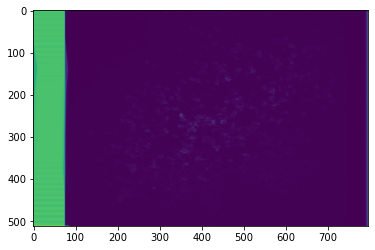

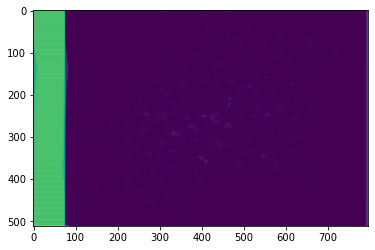

In [12]:
plt.figure()
plt.imshow(ops['meanImg_chan2'])

plt.figure()
plt.imshow(ops['meanImg'])

In [12]:
## Run the ROI extraction for the second channel
opsEnd=s2p.run_s2p(ops=ops)

{}
FOUND BINARIES AND OPS IN ['/data/2P/SparseKO_13/25_05_2025/YMaze_LNovel/YMaze_LNovel_002_008/chan2/suite2p/plane0/ops.npy']
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: /data/2P/SparseKO_13/25_05_2025/YMaze_LNovel/YMaze_LNovel_002_008/chan2/suite2p/plane0/data.bin
NOTE: applying default /home/mari/.suite2p/classifiers/classifier_user.npy
----------- ROI DETECTION
Binning movie in chunks of length 22
Binned movie [990,500,780] in 53.80 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 4.00 
0 ROIs, score=155.06
1000 ROIs, score=7.33
2000 ROIs, score=6.10
3000 ROIs, score=5.75
4000 ROIs, score=4.97
Detected 5000 ROIs, 64.24 sec
After removing overlaps, 3794 ROIs remain


cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


>>>> CELLPOSE estimating masks in anatomical channel
>>>> 122 masks detected, median diameter = 12.49 
ERROR importing or running cellpose, continuing without anatomical estimates
----------- Total 156.62 sec.
----------- EXTRACTION
Masks created, 4.01 sec.
Extracted fluorescence from 3794 ROIs in 22784 frames, 57.00 sec.
Extracted fluorescence from 3794 ROIs in 22784 frames, 56.91 sec.
----------- Total 119.32 sec.
----------- CLASSIFICATION
['skew', 'compact', 'npix_norm']
----------- Total 0.02 sec.
----------- SPIKE DECONVOLUTION
----------- Total 3.61 sec.
moving binary files to save_path
Plane 0 processed in 279.69 sec (can open in GUI).
total = 280.10 sec.
TOTAL RUNTIME 280.10 sec


In [63]:
## OPTIONAL delete copied binaries from the chan2 path to save disk space
!rm {ops['reg_file']}
!rm {ops['reg_file_chan2']} 

In [13]:
## Definitely do delete the .h5 to save space!
!rm {h5name} 